# Datadrift Analysis

## Import des Librairies

In [46]:
import pandas as pd
import numpy as np

import evidently
from evidently import ColumnMapping

from evidently.test_suite import TestSuite
from evidently.test_preset import NoTargetPerformanceTestPreset
from evidently.metric_preset import DataDriftPreset
import shap

import pickle
from backend import process_2
import os

In [2]:
SEED = 123

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

## Chargement des données et du modèle

In [4]:
%%time
train = pd.read_csv("application_train_prepro.csv", index_col="SK_ID_CURR")
test = pd.read_csv("input/application_test_prepro.csv",index_col="SK_ID_CURR")

CPU times: total: 5.78 s
Wall time: 4.98 s


In [5]:
%%time
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print('Train shape',train.shape)
print('Test shape',test.shape)
train.head()

Train shape (307511, 166)
Test shape (48744, 165)
CPU times: total: 0 ns
Wall time: 1.26 ms


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,mean_DAYS_CREDIT_ENDDATE,mean_DAYS_ENDDATE_FACT,mean_AMT_CREDIT_MAX_OVERDUE,mean_CNT_CREDIT_PROLONG,mean_AMT_CREDIT_SUM,mean_AMT_CREDIT_SUM_DEBT,mean_AMT_CREDIT_SUM_LIMIT,mean_AMT_CREDIT_SUM_OVERDUE,mode_CREDIT_TYPE,mean_DAYS_CREDIT_UPDATE
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,-452.8,-808.4,1312.0,0.0,111388.8,70223.1,3198.9,0.0,Credit card,-632.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,-544.5,-1097.3,0.0,0.0,254350.1,0.0,202500.0,0.0,Credit card,-472.2
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-488.5,-532.5,0.0,0.0,94518.9,0.0,0.0,0.0,Consumer credit,-532.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,-783.0,-783.0,0.0,0.0,146250.0,0.0,0.0,0.0,Consumer credit,-783.0


In [6]:
save_dir = 'obj_save/'
objects_to_save = ["model", "_scaler", "_impute", "_le", "feature_le_encoded", "_ohe"]

In [7]:
# Dictionnaire pour charger les objets sauvegardés
loaded_objects = {}

# Chargement des objets à partir des fichiers
for key in objects_to_save:
    with open(os.path.join(save_dir, f"{key}.pkl"), "rb") as read_file:
        loaded_objects[key] = pickle.load(read_file)

In [8]:
feature_le_encoded = loaded_objects["feature_le_encoded"]
loaded_model = loaded_objects["model"]

In [9]:
%%time
train_preprocess = process_2(train.drop(['TARGET'], axis=1), var=feature_le_encoded)

CPU times: total: 2min 19s
Wall time: 2min 21s


In [10]:
%%time
test_preprocess = process_2(test, var=feature_le_encoded)

CPU times: total: 18.8 s
Wall time: 19.4 s


## Prediction dans le set Train et Test

In [11]:
%%time
train_preprocess['prediction']= loaded_model.predict(train_preprocess)

CPU times: total: 2.86 s
Wall time: 1.35 s


In [12]:
%%time
test_preprocess['prediction']= loaded_model.predict(test_preprocess)

CPU times: total: 406 ms
Wall time: 176 ms


## Selection des features déterminants dans l'evolution du modèle

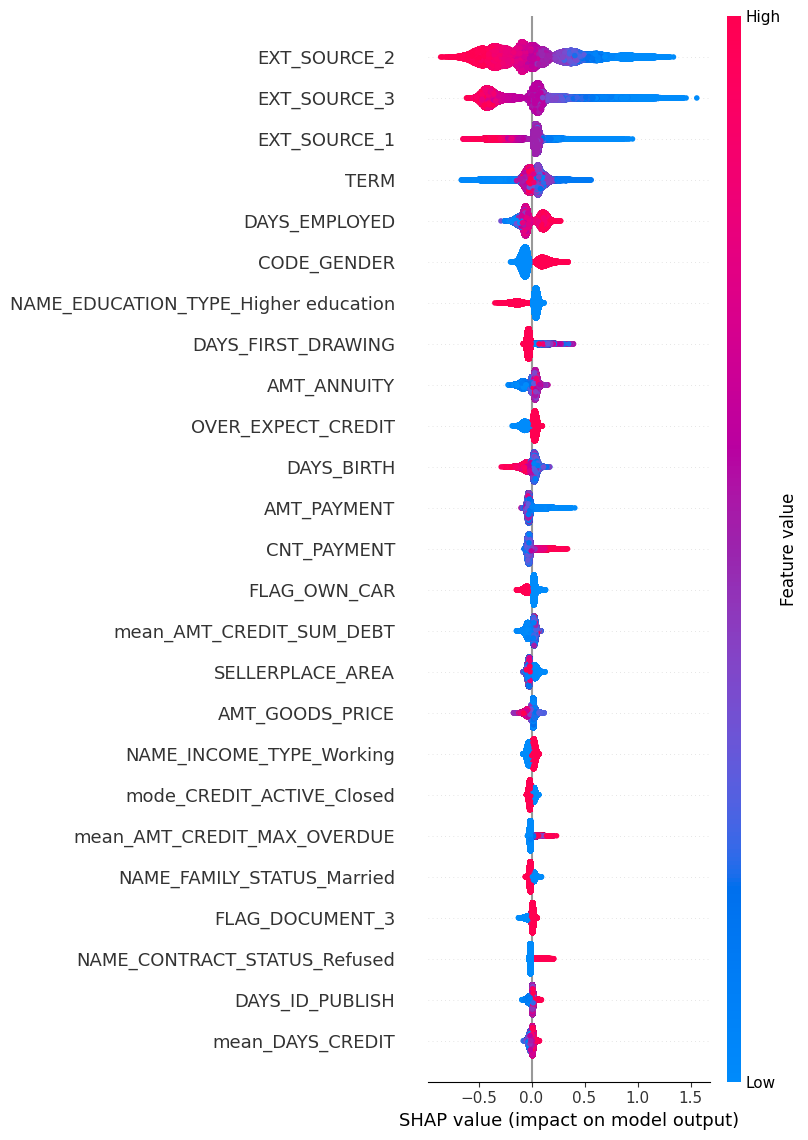

CPU times: total: 2min 40s
Wall time: 55.6 s


In [14]:
%%time
# Explain model predictions using shap library:
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(train_preprocess.drop(['prediction'], axis=1))

# Plot summary_plot and capture the output
summary_plot = shap.summary_plot(shap_values[1],train_preprocess.drop(['prediction'], axis=1), max_display=25, show=True)

In [16]:
# Obtenir les valeurs SHAP absolues moyennes pour chaque feature
mean_abs_shap_values = np.abs(shap_values[1]).mean(axis=0)

# Créer un DataFrame pour stocker les noms de features et leurs valeurs SHAP moyennes absolues
feature_importance = pd.DataFrame({
    'Feature': train_preprocess.drop(['prediction'], axis=1).columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values
})

# Trier le DataFrame par valeurs SHAP absolues moyennes en ordre décroissant
feature_importance= feature_importance.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Extraire les 25 premières features les plus importantes
top_features = feature_importance.head(25)['Feature'].tolist()

# Afficher la liste des 25 features les plus importantes
print("Top 25 features les plus importantes:\n")
print(top_features)

Top 25 features les plus importantes:

['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'TERM', 'DAYS_EMPLOYED', 'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher education', 'DAYS_FIRST_DRAWING', 'AMT_ANNUITY', 'OVER_EXPECT_CREDIT', 'DAYS_BIRTH', 'AMT_PAYMENT', 'CNT_PAYMENT', 'FLAG_OWN_CAR', 'mean_AMT_CREDIT_SUM_DEBT', 'SELLERPLACE_AREA', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE_Working', 'mode_CREDIT_ACTIVE_Closed', 'mean_AMT_CREDIT_MAX_OVERDUE', 'NAME_FAMILY_STATUS_Married', 'FLAG_DOCUMENT_3', 'NAME_CONTRACT_STATUS_Refused', 'DAYS_ID_PUBLISH', 'mean_DAYS_CREDIT']


## Report

### Construction des Dataframes de report

In [19]:
%%time
train_report = train_preprocess[top_features+['prediction']]
train_report.head()

CPU times: total: 1.42 s
Wall time: 1.46 s


,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,TERM,DAYS_EMPLOYED,CODE_GENDER,NAME_EDUCATION_TYPE_Higher education,DAYS_FIRST_DRAWING,AMT_ANNUITY,OVER_EXPECT_CREDIT,...,AMT_GOODS_PRICE,NAME_INCOME_TYPE_Working,mode_CREDIT_ACTIVE_Closed,mean_AMT_CREDIT_MAX_OVERDUE,NAME_FAMILY_STATUS_Married,FLAG_DOCUMENT_3,NAME_CONTRACT_STATUS_Refused,DAYS_ID_PUBLISH,mean_DAYS_CREDIT,prediction
0,0.307542,0.155054,0.072215,0.226047,0.964437,1.0,0.0,1.0,0.090032,1.0,...,0.077441,1.0,1.0,0.000011,0.0,1.0,0.0,0.705433,0.658795,1
1,0.727773,0.597163,0.312933,0.756604,0.933676,0.0,1.0,1.0,0.132924,1.0,...,0.271605,0.0,1.0,0.000000,1.0,1.0,0.0,0.959566,0.520534,0
2,0.650190,0.814130,0.518318,0.321005,0.987439,1.0,0.0,1.0,0.020025,0.0,...,0.023569,1.0,1.0,0.000000,0.0,0.0,0.0,0.648326,0.703285,0
3,0.760751,0.597163,0.518318,0.066977,0.830337,0.0,0.0,1.0,0.109477,1.0,...,0.063973,1.0,0.0,0.000000,0.0,1.0,0.0,0.661387,0.618070,0
4,0.377472,0.597163,0.518318,0.413888,0.830393,1.0,0.0,1.0,0.078975,0.0,...,0.117845,1.0,1.0,0.000000,0.0,0.0,0.0,0.519522,0.606776,0


In [20]:
%%time
test_report = test_preprocess[top_features+['prediction']]
test_report.head()

CPU times: total: 188 ms
Wall time: 345 ms


,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,TERM,DAYS_EMPLOYED,CODE_GENDER,NAME_EDUCATION_TYPE_Higher education,DAYS_FIRST_DRAWING,AMT_ANNUITY,OVER_EXPECT_CREDIT,...,AMT_GOODS_PRICE,NAME_INCOME_TYPE_Working,mode_CREDIT_ACTIVE_Closed,mean_AMT_CREDIT_MAX_OVERDUE,NAME_FAMILY_STATUS_Married,FLAG_DOCUMENT_3,NAME_CONTRACT_STATUS_Refused,DAYS_ID_PUBLISH,mean_DAYS_CREDIT,prediction
0,0.923573,0.177549,0.778428,0.526667,0.869975,0.0,1.0,1.000000,0.073886,1.0,...,0.102132,1.0,1.0,0.000000,1.0,1.0,0.0,0.887175,0.654689,0
1,0.341118,0.482907,0.580538,0.128479,0.750502,1.0,0.0,1.000000,0.061443,1.0,...,0.034792,1.0,1.0,0.000000,1.0,1.0,0.0,0.774489,0.906913,0
2,0.818464,0.681715,0.518318,0.039412,0.751117,1.0,1.0,1.000000,0.265830,1.0,...,0.147026,1.0,1.0,0.000166,1.0,0.0,0.0,0.513269,0.382272,0
3,0.596114,0.683628,0.539134,0.646501,0.895824,0.0,0.0,0.259864,0.184872,0.0,...,0.382716,1.0,1.0,0.000000,1.0,1.0,0.0,0.415312,0.424709,0
4,0.497880,0.597163,0.197840,0.307750,0.877680,1.0,0.0,1.000000,0.118761,0.0,...,0.145903,1.0,0.0,0.000000,1.0,1.0,0.0,0.407809,0.618070,0


In [21]:
train_report.columns

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'TERM', 'DAYS_EMPLOYED',
       'CODE_GENDER', 'NAME_EDUCATION_TYPE_Higher education',
       'DAYS_FIRST_DRAWING', 'AMT_ANNUITY', 'OVER_EXPECT_CREDIT', 'DAYS_BIRTH',
       'AMT_PAYMENT', 'CNT_PAYMENT', 'FLAG_OWN_CAR',
       'mean_AMT_CREDIT_SUM_DEBT', 'SELLERPLACE_AREA', 'AMT_GOODS_PRICE',
       'NAME_INCOME_TYPE_Working', 'mode_CREDIT_ACTIVE_Closed',
       'mean_AMT_CREDIT_MAX_OVERDUE', 'NAME_FAMILY_STATUS_Married',
       'FLAG_DOCUMENT_3', 'NAME_CONTRACT_STATUS_Refused', 'DAYS_ID_PUBLISH',
       'mean_DAYS_CREDIT', 'prediction'],
      dtype='object')

In [23]:
categorical_feature =train_report.filter(regex='^(NAME|CODE|OVER|FLAG)', axis=1).columns.to_list()
numerical_feature = train_report.columns[~train_report.columns.isin(categorical_feature+['prediction'])]
train_report[categorical_feature] = train_report[categorical_feature].astype('object')
test_report[categorical_feature] = test_report[categorical_feature].astype('object')

In [24]:
train_report.dtypes

EXT_SOURCE_2                            float64
EXT_SOURCE_3                            float64
EXT_SOURCE_1                            float64
TERM                                    float64
DAYS_EMPLOYED                           float64
CODE_GENDER                              object
NAME_EDUCATION_TYPE_Higher education     object
DAYS_FIRST_DRAWING                      float64
AMT_ANNUITY                             float64
OVER_EXPECT_CREDIT                       object
DAYS_BIRTH                              float64
AMT_PAYMENT                             float64
CNT_PAYMENT                             float64
FLAG_OWN_CAR                             object
mean_AMT_CREDIT_SUM_DEBT                float64
SELLERPLACE_AREA                        float64
AMT_GOODS_PRICE                         float64
NAME_INCOME_TYPE_Working                 object
mode_CREDIT_ACTIVE_Closed               float64
mean_AMT_CREDIT_MAX_OVERDUE             float64
NAME_FAMILY_STATUS_Married              

### Columnmaping

In [25]:
column_mapping = ColumnMapping()

In [26]:
column_mapping = ColumnMapping()
column_mapping.numerical_features = numerical_feature
column_mapping.categorical_features = categorical_feature
column_mapping.prediction= 'prediction'

### Echantillonage 

In [27]:
train_report.shape[0]/test_report.shape[0]

6.308694403413753

In [41]:
reference = train_report.sample(n=40000, replace=False, random_state=42)
current = test_report.sample(n=40000, replace=False, random_state=42)

## Generons le rapport

In [73]:
report = TestSuite(tests=[
    NoTargetPerformanceTestPreset(cat_stattest='psi' , cat_stattest_threshold=0.05)
])

report.run(reference_data=reference, current_data=current)

In [74]:
report.save_html("datadrift-analysis-report.html")